# SunPy: coding to analyse signals from the Sun

The SunPy library provides various modules for the conversion and transformation of electromagnetic signals emitted from the Sun. It is widely used among astrophysical research communities. However, it is also a valuable tool to experiment with high-volume data. In this walkthrough, I will demonstrate some common ways to explore these solar data resources.

Installation: 

```
pip install sunpy
pip install zeep
pip install drms
```

## Short description

SunPy is a community-developed free and open-source software package for solar physics. SunPy is meant to be a free alternative to [SolarSoft](https://www.lmsal.com/solarsoft/) and its aim is to provide the software tools necessary so that anyone can analyze solar data. 

## Software development progress
Previous versions of SunPy:
* 0.1 in 2011
* 0.5 in 2015 (~ 20k lines of code)
* 1.0 in 2019 (~ 30k lines of code, porting to Python 3.0)

## Typical uses


* Query and download data from many different solar missions and instruments via a general, standard, and consistent interface.
* Load and visualize time series data — measurements of how, say, a particular type of flux from a region changes over time — and images.
* Perform transformations between the variety of coordinate systems commonly used to describe events and features both on the Sun and within the heliosphere.


A survey carried out by Bobra et al. (2020) reveals that Python and IDL are two main programming tools used in astronomy and astrophysics researchers, with the trend of "younger" respondents tend to use more Python.
![use-IDL-Python.PNG](SunPy_survey_IDL_vs_Python.webp)

## 1. Reading and displaying maps of the Sun

This [example](https://docs.sunpy.org/en/stable/generated/gallery/plotting/finding_local_peaks_in_solar_data.html#sphx-glr-generated-gallery-plotting-finding-local-peaks-in-solar-data-py) shows how to download and display a map for a sample AIA image data. [AIA](https://aia.lmsal.com/) (The Atmospheric Imaging Assembly) provides imaging of the solar atmosphere in multiple wavelengths to link changes in the surface to interior changes. Data includes images of the Sun in 10 wavelengths every 10 seconds.

The first time you run the code block, it could take a long time and not all files may be downloaded. Once you have imported `AIA_193_IMAGE`, you can rerun the code without having to wait!

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

import sunpy.map
from sunpy.data.sample import AIA_193_IMAGE
from sunpy.map.maputils import all_pixel_indices_from_map

aiamap = sunpy.map.Map(AIA_193_IMAGE)

Here is the map of the sun:

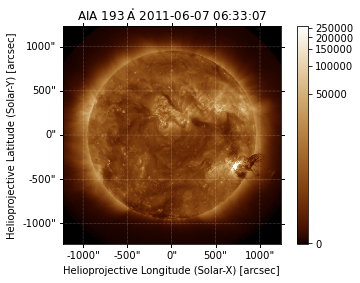

In [6]:
plt.figure()
aiamap.plot()
plt.colorbar()

Next, we will [find local peaks](https://docs.sunpy.org/en/stable/generated/gallery/plotting/finding_local_peaks_in_solar_data.html#sphx-glr-generated-gallery-plotting-finding-local-peaks-in-solar-data-py) in this dataset.

For this task we need Scikit-image, which can be installed via

`pip install scikit-image`

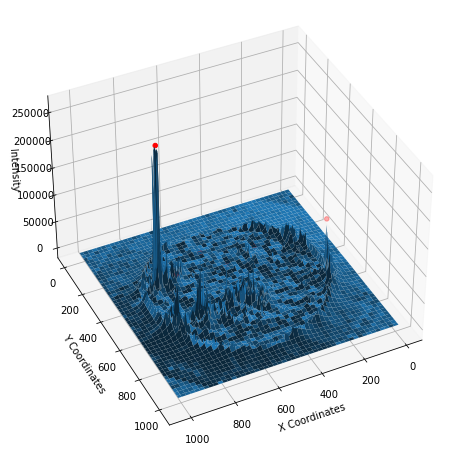

In [8]:
from skimage.feature import peak_local_max

X, Y = all_pixel_indices_from_map(aiamap)
coordinates = peak_local_max(aiamap.data, min_distance=60, threshold_rel=0.2)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, aiamap.data)
ax.view_init(elev=39, azim=64)
peaks_pos = aiamap.data[coordinates[:, 0], coordinates[:, 1]]
ax.scatter(coordinates[:, 1], coordinates[:, 0], peaks_pos, color='r')
ax.set_xlabel('X Coordinates')
ax.set_ylabel('Y Coordinates')
_ = ax.set_zlabel('Intensity')

The `x` and `y` coordinates of these local peaks (2) are stored in the `coordinates` array. You may noticed that the pixel indices are different from the solar coordinates in arcsecs. 

In [66]:
print(coordinates)

[[365 808]
 [629 735]
 [592 123]
 [632 842]
 [582 460]
 [573 587]]


Hence, we have to transform these coordinates into the "sun" or `world` coordinates, and then show them on the map. This can be accomplished by using the `plot_coord` method and the auxiliary `units` module:

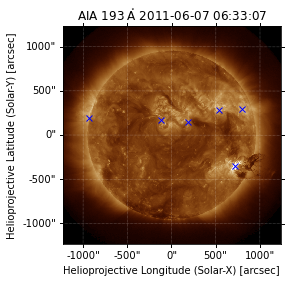

In [67]:
import astropy.units as u

hpc_max = aiamap.pixel_to_world(coordinates[:, 1]*u.pixel, coordinates[:, 0]*u.pixel)

fig = plt.figure()
ax = plt.subplot(projection=aiamap)
aiamap.plot()
ax.plot_coord(hpc_max, 'bx')

plt.show()

With additional tools such as `scipy.ndimage`, you can perform image enhancing algorithms to detect the coronal loops, as shown [here](https://docs.sunpy.org/en/stable/generated/gallery/computer_vision_techniques/loop_edge_enhance.html#sphx-glr-generated-gallery-computer-vision-techniques-loop-edge-enhance-py). Can you apply this for the current `AIA_131_IMAGE`?

## 1b. Displaying maps for local files

Data files may pre-exist in your local drive. If so, you can directly showing maps without downloading. We already have the file `20170707_000815_n4c2A.fts.gz`  in the `SECCHI` subfolder. This is a SECCHI file obtained with [LASCO](https://lasco-www.nrl.navy.mil/) instrument. Particularly, SECCHI is a suite of 5 scientific telescopes that will observe the solar corona and inner heliosphere from the surface of the Sun to the orbit of Earth. The file corresponds to SECCHI STEREO COR-2a (meaning that the image data was obtained from the (STEREO-A) spacecraft travelling ahead along the heliocentric orbit).

In [21]:
from astropy.io.fits import getdata
image, header = getdata('SECCHI/20170707_000815_n4c2A.fts.gz', header=True)

The data file contains an HDU (header data unit), from which we can extract an image (matrix) and a header (a structure including the "metadata").

In [58]:
hdu = sunpy.io.read_file('SECCHI/20170707_000815_n4c2A.fts.gz')
image = hdu[0][0]
header = hdu[0][1]

print(type(image))
print(type(header))

<class 'numpy.ndarray'>
<class 'sunpy.io.header.FileHeader'>


For the image, we can manipulate using `numpy`:

In [41]:
import numpy as np
import pandas as pd
from scipy import stats

print(image.shape)
print('Min: ', np.min(image), ' Max: ', np.max(image))
print(f'Mean: {np.mean(image):.2f} Std dev.: {np.std(image):.2f}')

(2048, 2048)
Min:  2052  Max:  12556
Mean: 2318.71 Std dev.: 372.61


For the header, we can access and manipulate as if it was a Python dictionary: 

In [61]:
print(len(header))
print('Device type: ', header['INSTRUME'], header['DETECTOR'])
print('Date: ', header['DATE-OBS'])

241
Device type:  SECCHI COR2
Date:  2017-07-07T00:08:15.006


If you want to plot the map of this image, just use `sunpy.map.Map`, but passing the full-path file name, similar to that done with the predefined sample `AIA_193_IMAGE`.

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


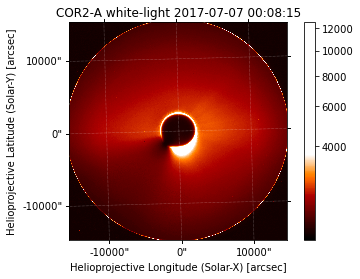

In [65]:
fitsmap = sunpy.map.Map('SECCHI/20170707_000815_n4c2A.fts.gz')
plt.figure()
fitsmap.plot()
_ = plt.colorbar()

## 2. Downloading files

Data files can be downloaded via the [`Fido` interface](https://openastronomy.org/rcsc18/chapters/14-searching-and-downloading-data/01-searching-and-downloading-data#fido). 

We need additional libraries `zeep` and `drms` for this task.

Install (within Jupyter notebook):

```
!pip install zeep
!pip install drms
```

In this example, we first query the SECCHI data files available from `Fido` in a one-day time interval from `2017/07/06 00:00` to `2017/07/07 00:00`.

In [ ]:
from sunpy.net import Fido
from sunpy.net import attrs as a

results = Fido.search(a.Time('2017/07/06 00:00', '2017/07/07 00:00'), a.Instrument.secchi)
secchi = results[0]
secchi

Now look at the `Info` and `fileid` fields; we would like to filter out, from the search results to:

* `Info` starts with `NORMAL`
* `Info` contains `NORMAL`
* `Info` contains `0deg.`
* `fileid` contains `fts`

In [70]:
idx_list = []
counter = 0
for rec in secchi:
    recinfo = rec['Info']
    recfileid = rec['fileid']
    if recinfo.startswith('COR2') and ('NORMAL' in recinfo) and ('0deg.' in recinfo) and ('fts' in recfileid):
        idx_list += [counter]

    counter += 1

print(idx_list)

[12, 13, 14, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 35, 36, 37, 38, 39, 40, 41, 42, 108, 109, 110, 111, 112, 113, 114, 115, 119, 120, 121, 122, 123, 124, 125, 126, 130, 131, 132, 133, 134, 135, 136, 137, 200, 201, 202, 203, 204, 205, 206, 207, 211, 212, 213, 214, 215, 216, 217, 218, 224, 225, 226, 227, 228, 229, 230, 231, 296, 297, 298, 299, 300, 301, 302, 303, 307, 308, 309, 310, 311, 312, 313, 314, 318, 319, 320, 321, 322, 323, 324, 325, 388, 389, 390, 391, 392, 393, 394, 395, 399, 400, 401, 402, 403, 404, 405, 406, 412, 413, 414, 415, 416, 417, 418, 419, 484, 485, 486, 487, 488, 489, 490, 491, 495, 496, 497, 498, 499, 500, 501, 502, 506, 507, 508, 509, 510, 511, 512, 513, 625, 626, 627, 628, 629, 630, 631, 632, 636, 637, 638, 639, 640, 641, 642, 643, 649, 650, 651, 652, 653, 654, 655, 656, 721, 722, 723, 724, 725, 726, 727, 728, 732, 733, 734, 735, 736, 737, 738, 739, 743, 744, 745, 746, 747, 748, 749, 750, 813, 814, 815, 816, 817, 818, 819, 820, 824, 825, 826, 827, 828

OK, we can download the first 5 files:

In [72]:
shortlist = secchi[idx_list[:5]]

from datetime import datetime
import time

for single in shortlist:
    start_time = single['Start Time']
    single_time = datetime.strptime(str(start_time), '%Y-%m-%d %H:%M:%S.000')
    yr = single_time.year
    mo = single_time.month
    dday = single_time.day
    the_path = '.'
    time.sleep(2)   # suspend to avoid locking download by the server
    try:
        _ = Fido.fetch(single, max_conn=2, path=the_path+'/{file}')
    except RuntimeError:
        print("ERROR: Download unsuccessful!")

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

20170706_000815_n4c2a.fts:   0%|          | 0.00/8.42M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

## References


Bobra, M.G., Mumford, S.J., Hewett, R.J. et al. (2020). A Survey of Computational Tools in Solar Physics. Sol Phys 295, 57. https://doi.org/10.1007/s11207-020-01622-2

Eichhorn, H. (2021) A Short History of AstroTime.jl. JuliaCon 2021.

The SunPy Community et al. (2020). “The SunPy Project: Open Source Development and Status of the Version 1.0 Core Package,” ApJ 890 68. doi:10.3847/1538-4357/ab4f7a

The SunPy Community (2021). SunPy 3.0.1 Documentation. https://docs.sunpy.org/en/stable/index.html

Wikipedia (2021). International Atomic Time.

![Aberystwyth University](aber-logo.PNG)

Nguyen Quang Chien 

Department of Physics

Currently working for the [Solar Research Group](https://solarphysics.aber.ac.uk/)